In [31]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Beyond Single Runs: Tendency Analysis of Non-Deterministic Eval Tasks



<table align="left">

</table>

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fapplied-ai-engineering-samples%2Fmain%2Fgenai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/applied-ai-engineering-samples/main/genai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/vertex_evaluation_services/tendency-based-evaluation/Beyond_Single_Runs_Tendency_Analysis_of_Non_Deterministic_Eval_Tasks.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author(s) | [Alejandro Ballesta](https://www.linkedin.com/in/alejandroballestae/) |

**_NOTE_**: This notebook has been tested in the following environment:

* Python version >= 3.10

## Overview

This notebook explores the application of statistical methods to gain insights into the behavior of the **Vertex AI Python SDK for Gen AI Evaluation Service** for generated answers during **Question Answering** (QA) tasks. Due to the inherent variability, non-deterministic or probabilistic outcomes in these tasks, relying on a single execution may not provide a comprehensive understanding of the real performance.


We'll delve into techniques to aggregate and analyze results from multiple runs, enabling us to:
* **Identifying the problem:** running multiple tests over the same data to understand the non-deterministic outputs
* **Setting up a more reliable approach:** using the same pair of questions and contexts, we will use the generated answers of two different models (ex. Gemini 1.5 vs Gemini Flash) as an input to our method and demonstrate an extensive methodology to derive better conclusions
* **Running the experiment:** for each model, we will run the QA Gen AI Evaluation Service method 40 times to extract multiple performance metrics
* **Quantifying Performance:** we will calculate key statistical measures like mean, median, and standard deviation to gauge central tendency and variability across executions.
* **Identifying Performance:** In this section, using the statistical measures calculated, we will visualize the distributions of each metric overlapping the results of both models in the same chart
* **Assessing Confidence:** applying confidence intervals or hypothesis testing we will draw statistically sound conclusions about the performance of eval tasks.
By leveraging these statistical tools, we aim to move beyond single-run observations and gain a more robust understanding of the true behavior and capabilities of these non-deterministic tasks.
* **Comparing Results:** we will plot a radar chart and determine which model is better for our own goals

**Note:** The purpose of this analysis is not to have a completely statistical (since we are making a lot of assumptions) proof, but to gain a more holistic view of the architecture's performance

[Documentation Reference]( https://cloud.google.com/vertex-ai/generative-ai/docs/models/evaluation-overview)

## Getting Started

### Install Vertex AI SDK for Gen AI Evaluation Service

In [32]:
%pip install --upgrade --user --quiet google-cloud-aiplatform[evaluation]
%pip install --quiet --upgrade nest_asyncio


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Restart runtime
To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [33]:
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

### Authenticate your notebook environment (Colab only)

In [34]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

In [36]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
LOCATION = "[your-location]"  # @param {type:"string"}
PROJECT_ID = "golf-demo-abr"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Import libraries

In [37]:
# General
from IPython.display import display, Markdown, HTML
import logging
import nest_asyncio
import warnings

# Main
from vertexai.preview.evaluation import EvalTask
import pandas as pd

### Library settings

In [38]:
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)
nest_asyncio.apply()
warnings.filterwarnings("ignore")

# **Identifying the problem**
In this section we are going to run 2 independent evaluation tasks and gather evidence of different results under the same following conditions:
* **Questions:** set of 5 random questions (same questions for each test)
* **Retrieved context:** for the purpose of this notebook we assume that the context is retrieved with any particular method
* **Generated answers:** examples of text generated by the models


## Prepare Dataset

To evaluate the RAG generated answers, the evaluation dataset is required to contain the following fields:

* Question
* Context
* RAG Generated Answer

In [39]:
questions = [
    "Which part of the brain does short-term memory seem to rely on?",
    "What provided the Roman senate with exuberance?",
    "What area did the Hasan-jalalians command?",
    "How many pencils could be made from the carbon in an average adult human body?"
]

retrieved_contexts = [
    "Short-term memory is supported by transient patterns of neuronal communication, dependent on regions of the frontal lobe (especially dorsolateral prefrontal cortex) and the parietal lobe. Long-term memory, on the other hand, is maintained by more stable and permanent changes in neural connections widely spread throughout the brain. The hippocampus is essential (for learning new information) to the consolidation of information from short-term to long-term memory, although it does not seem to store information itself. Without the hippocampus, new memories are unable to be stored into long-term memory, as learned from patient Henry Molaison after removal of both his hippocampi, and there will be a very short attention span. Furthermore, it may be involved in changing neural connections for a period of three months or more after the initial learning.",
    "In 62 BC, Pompey returned victorious from Asia. The Senate, elated by its successes against Catiline, refused to ratify the arrangements that Pompey had made. Pompey, in effect, became powerless. Thus, when Julius Caesar returned from a governorship in Spain in 61 BC, he found it easy to make an arrangement with Pompey. Caesar and Pompey, along with Crassus, established a private agreement, now known as the First Triumvirate. Under the agreement, Pompey's arrangements would be ratified. Caesar would be elected consul in 59 BC, and would then serve as governor of Gaul for five years. Crassus was promised a future consulship.",
    "The Seljuk Empire soon started to collapse. In the early 12th century, Armenian princes of the Zakarid noble family drove out the Seljuk Turks and established a semi-independent Armenian principality in Northern and Eastern Armenia, known as Zakarid Armenia, which lasted under the patronage of the Georgian Kingdom. The noble family of Orbelians shared control with the Zakarids in various parts of the country, especially in Syunik and Vayots Dzor, while the Armenian family of Hasan-Jalalians controlled provinces of Artsakh and Utik as the Kingdom of Artsakh.",
    "The average adult human body contains enough carbon to make about 900 pencils"
]

generated_answers = [
    "frontal lobe and the parietal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded the area of Syunik and Vayots Dzor.",
    "around 901"
]


eval_dataset = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers,
    }
)

## Select Metric and Define EvalTask


Choose from the following metrics for an evaluation task. For more information about the supported evaluation metrics and how to use each metric, please see [Evaluation methods and metrics](https://cloud.google.com/vertex-ai/generative-ai/docs/models/determine-eval).

*   `question_answering_quality` (overall quality)
*   `question_answering_relevance`
*   `question_answering_helpfulness`
*   `fulfillment`

You can run evaluation for just one metric, or a combination of metrics. For example, we create an `EvalTask` named `answer_eval_task` with all the QA-related metrics to compute all the metrics in one eval run as follows:

In [40]:
answer_eval_task = EvalTask(
    dataset=eval_dataset,
    metrics=[
        "question_answering_quality",
        "coherence",
        "fluency",
        "verbosity"
    ],
    experiment="rag-eval-01",
)

## Run Evaluation

In [ ]:
first_result = answer_eval_task.evaluate()
second_result = answer_eval_task.evaluate()

In [42]:
first_result.summary_metrics

{'row_count': 4,
 'question_answering_quality/mean': np.float64(3.25),
 'question_answering_quality/std': np.float64(1.2583057392117916),
 'coherence/mean': np.float64(2.75),
 'coherence/std': np.float64(1.707825127659933),
 'fluency/mean': np.float64(3.25),
 'fluency/std': np.float64(1.5),
 'verbosity/mean': np.float64(-1.0),
 'verbosity/std': np.float64(0.816496580927726)}

#Let's compare the results of running the same experiment twice

In [43]:
first_df = pd.DataFrame(first_result.metrics_table)
second_df = pd.DataFrame(second_result.metrics_table)

first_df = first_df.add_prefix('first_')
second_df = second_df.add_prefix('second_')

result = pd.concat([first_df, second_df], axis=1)
result[["first_question_answering_quality/score","second_question_answering_quality/score"]]


,first_question_answering_quality/score,second_question_answering_quality/score
0,3.0,3.0
1,3.0,3.0
2,5.0,5.0
3,2.0,3.0


You are probably seeing different results (row 3) for at least one row; if not, try again
:)

# **Setting up a more reliable approach**

if you are comparing two different architectures (Ex, Gemini 1.5 generations vs Gemini Flash generations), it's recommended to use sample distributions to understand the perfomance of each approach.

Let's see one example


## Modal A vs Model B set up

In [44]:
generated_answers_modal_a = [
    "frontal lobe and the parietal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded the area of Syunik and Vayots Dzor.",
    "around 900 pencils could be made from an adult human body"
]

generated_answers_model_b = [
    "frontal lobe",
    "The Roman Senate was filled with exuberance due to successes against Catiline.",
    "The Hasan-Jalalians commanded Vayots Dzor",
    "I would guess 901"
]

eval_dataset_model_a = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers_modal_a,
    }
)
eval_dataset_model_b = pd.DataFrame(
    {
        "prompt": questions,
        "context": retrieved_contexts,
        "response": generated_answers_model_b,
    }
)

#**Running the experiment**

Once the answers have been generated, let's run 40 identical experiments for each approach

In [45]:
#Let's first define the metrics we are going to use

metrics = ["question_answering_quality",
        "coherence",
        "fluency",
        "verbosity"]
n=40

In [ ]:
#Model A - 40 iteration evaluation

model_a_results = []
for i in range(n):
  print(f"running experiment {i}-------------------")
  answer_eval_task = EvalTask(
      dataset=eval_dataset_model_a,
      metrics=metrics,
      experiment=f"rag-model-a-1-5-eval-{i}",
  )
  model_a_results.append(answer_eval_task.evaluate().summary_metrics)

In [ ]:
#Model B- 40 iteration evaluation

model_b_results = []
for i in range(n):
  print(f"running experiment {i}-------------------")
  answer_eval_task = EvalTask(
      dataset=eval_dataset_model_b,
      metrics=metrics,
      experiment=f"rag-model-b-eval-{i}",
  )
  model_b_results.append(answer_eval_task.evaluate().summary_metrics)

#**Quantifying Performance**

##Get the mean of each summary metric for the 40 experiments

In [48]:
mean_metrics = [
    "question_answering_quality/mean",
    "coherence/mean",
    "fluency/mean",
    "verbosity/mean",
]

average_metrics_model_a = model_a_results_df[mean_metrics].mean()


average_metrics_model_a

question_answering_quality/mean    3.625000
coherence/mean                     3.293750
fluency/mean                       3.572938
verbosity/mean                    -0.793750
dtype: float64

In [49]:

average_metrics_model_b = model_b_results_df[mean_metrics].mean()


average_metrics_model_b

question_answering_quality/mean    3.15750
coherence/mean                     2.83125
fluency/mean                       3.46250
verbosity/mean                    -1.24375
dtype: float64

#**Identifying Performance and Assessing Confidence**

In this section we procced to create distribution charts for the mean of each metric evaluated per model/approach. We overlap the results of Model A on top of Model B outcomes and evidence the gaps between them.

For each metric, we are also calculating the difference of the mean between the two series and also running a t-test so we can have certainty about our conclusions. If the test is statistically significant it means the difference might be consistent enough to determine a clear winner.

Why the **Independent Samples t-test**?

* **Continuous Data**: The quality scores (0-5) are continuous numerical data, suitable for a t-test.
Two Independent Groups: You have two separate sets of results (series), and you want to compare their means.
* **Assumption of Normality**: The t-test assumes that the data within each group is approximately normally distributed. While you have a limited sample size (40), if the distribution of scores isn't heavily skewed or has extreme outliers, the t-test is reasonably robust.


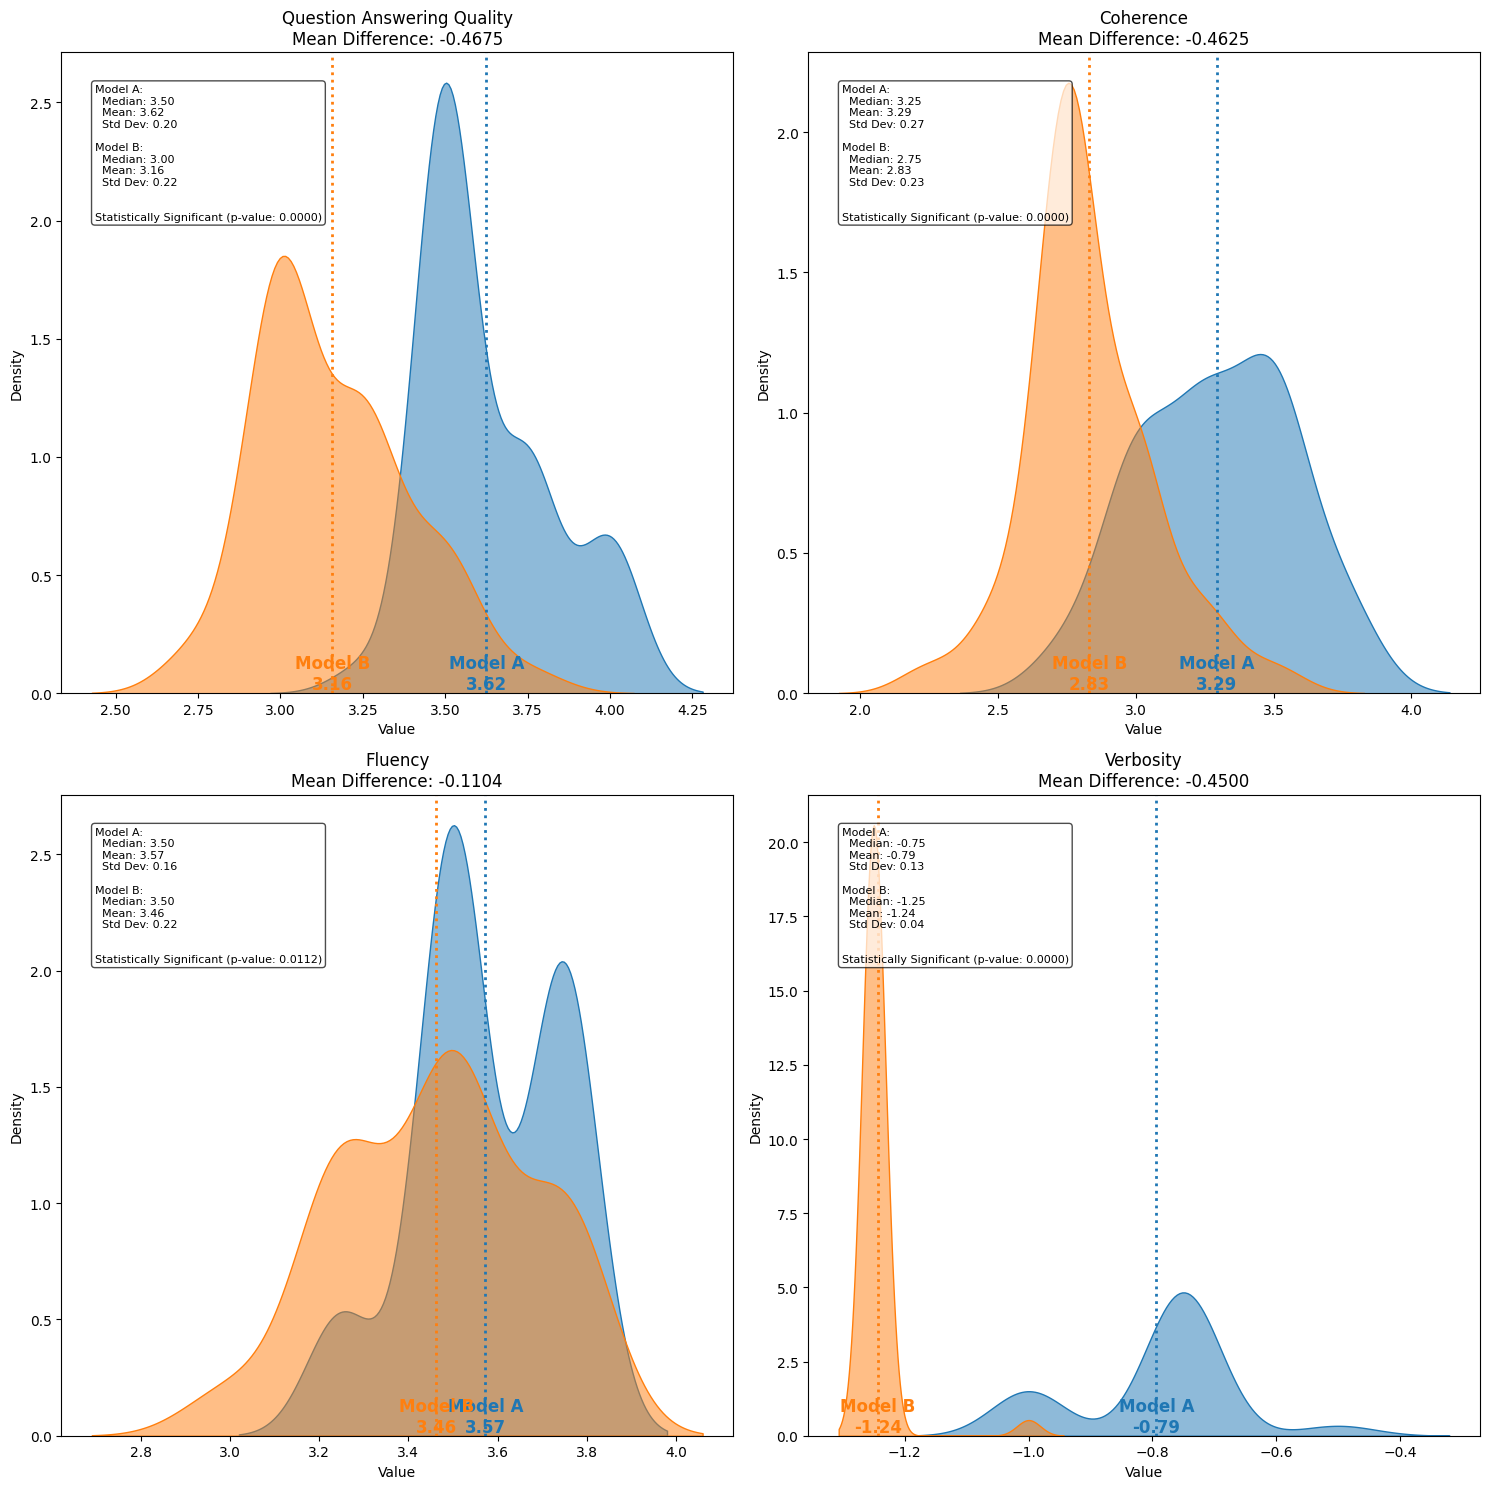

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sample data
dataframes = [model_a_results_df, model_b_results_df]
dataframe_names = ["Model A", "Model B"]


# Create KDE plots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
# Define a color palette
colors = ['#1f77b4', '#ff7f0e']  # You can add more colors if you have more dataframes

for i, metric in enumerate(mean_metrics):
    row, col = i // 2, i % 2

    means = []
    for df, name, color in zip(dataframes, dataframe_names, colors):
        # Plot KDE
        sns.kdeplot(data=df[metric], ax=axs[row, col], fill=True, alpha=0.5, label=name, color=color)

        # Calculate mean and plot dotted line
        mean_value = df[metric].mean()
        means.append(mean_value)
        axs[row, col].axvline(mean_value, color=color, linestyle=':', linewidth=2)

    # Calculate mean difference and perform t-test
    mean_diff = means[1] - means[0]
    t_stat, p_value = stats.ttest_ind(dataframes[0][metric], dataframes[1][metric])

    title = metric.split('/')[0].replace("_", " ").title()
    diff_title = f"{title}\nMean Difference: {mean_diff:.4f}"
    axs[row, col].set_title(diff_title, fontsize=12)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')


    # Add value labels at the bottom
    ylim = axs[row, col].get_ylim()
    for df, name, color, mean in zip(dataframes, dataframe_names, colors, means):
        axs[row, col].text(mean, ylim[0], f'{name}\n{mean:.2f}', color=color,
                           ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Add text annotations
    stats_text = ""
    for df, name in zip(dataframes, dataframe_names):
        median = df[metric].median()
        mean = df[metric].mean()
        std = df[metric].std()
        stats_text += f'{name}:\n  Median: {median:.2f}\n  Mean: {mean:.2f}\n  Std Dev: {std:.2f}\n\n'

    # Add statistical significance information
    if p_value < 0.02:
        sig_text = f"Statistically Significant (p-value: {p_value:.4f})"
    else:
        sig_text = f"Not Statistically Significant (p-value: {p_value:.4f})"

    stats_text += f"\n{sig_text}"

    axs[row, col].text(0.05, 0.95, stats_text,
                       transform=axs[row, col].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
                       fontsize=8)

# Remove extra subplot
if len(metrics) % 2 != 0:
    axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()

These charts illustrate the performance of the two models across various metrics.  Model A generally demonstrates better quality, verbosity, and coherence than Model B. However, there is no statistically significant difference between the models in terms of fluency.

**Note:** We can evidence that sometimes the normal distribution is not as clear as other times, that is why is important to look at the charts before making any definitive conclusion

# **Comparing Results**

Now we can plot a more general overlapping view using a radar chart to understand in which areas the approaches differ

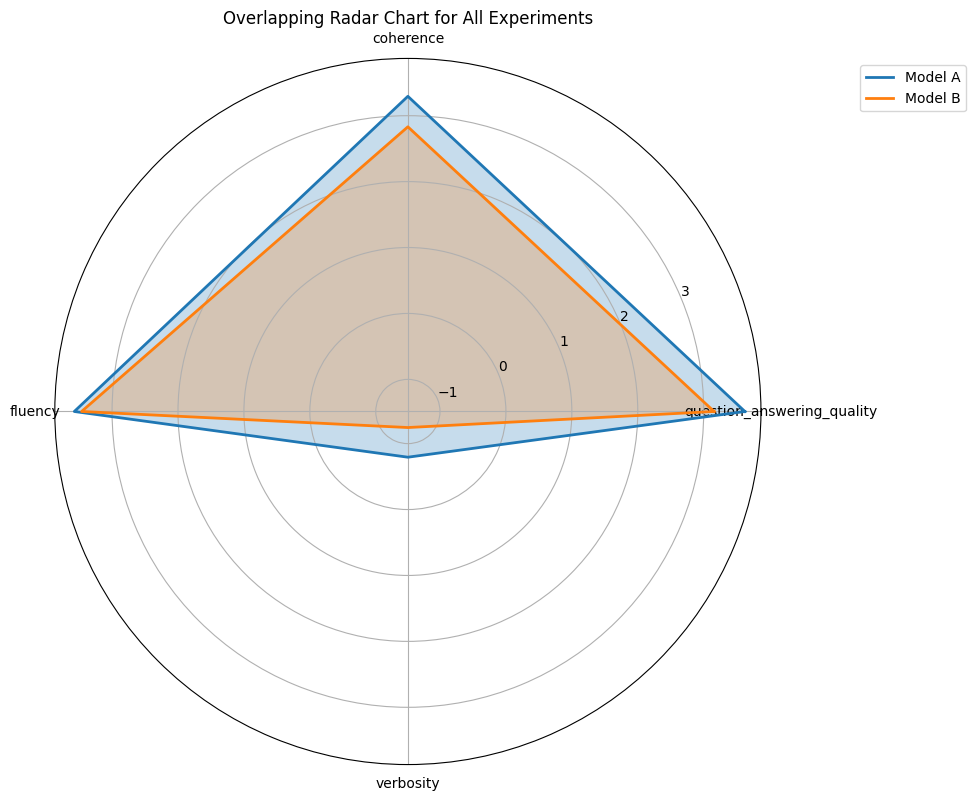

In [51]:
# Function to create radar chart
def radar_chart(data, title):
    angles = np.linspace(0, 2*np.pi, len(mean_metrics), endpoint=False)
    values = data[mean_metrics].mean().values
    values = np.concatenate((values, [values[0]]))  # repeat the first value to close the polygon
    angles = np.concatenate((angles, [angles[0]]))  # repeat the first angle to close the polygon

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.split('/')[0] for m in mean_metrics], wrap=True)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# # Create radar charts for each dataframe
# for df, name in zip(dataframes, dataframe_names):
#     radar_chart(df, f'Radar Chart for {name}')

# Create overlapping radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

angles = np.linspace(0, 2*np.pi, len(mean_metrics), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # repeat the first angle to close the polygon

for df, name in zip(dataframes, dataframe_names):
    values = df[mean_metrics].mean().values
    values = np.concatenate((values, [values[0]]))  # repeat the first value to close the polygon
    ax.plot(angles, values, linewidth=2, label=name)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.split('/')[0] for m in mean_metrics], wrap=True)
ax.set_title('Overlapping Radar Chart for All Experiments')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

## Conclusions

In this notebook, we demonstrated the power of statistical analysis in understanding the performance of non-deterministic eval tasks. By leveraging techniques like the independent samples t-test, we moved beyond single-run observations to gain a more comprehensive understanding of the variability and underlying trends in our results.

The insights gleaned from this analysis can inform future iterations of the eval task, guide decision-making based on statistically sound evidence, and pave the way for more robust and reliable evaluations in the face of inherent uncertainty.

Note: The purpose of this analysis is not to have a rigorous statistical proof (since we are making a lot of assumptions), but to gain a more holistic view of the architecture's performance